In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import Input, Model
import os

2024-02-11 15:59:50.690417: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 15:59:50.738686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train = np.load('./data/CompleteDataSet_training_tuples.npy', allow_pickle=True)
valid = np.load('./data/CompleteDataSet_validation_tuples.npy', allow_pickle=True)
test = np.load('./data/CompleteDataSet_testing_tuples.npy', allow_pickle=True)

In [4]:
train_x = train[:,0]
train_y = train[:,1]
valid_x = valid[:,0]
valid_y = valid[:,1]
test_x = test[:,0]
test_y = test[:,1]

In [5]:
train_x.shape

(200331,)

In [6]:
valid_x.shape

(66777,)

In [7]:
train_x = np.concatenate((train_x, valid_x), axis=0)
train_y = np.concatenate((train_y, valid_y), axis=0)

In [8]:
train_x.shape

(267108,)

In [9]:
train_y.shape

(267108,)

In [10]:
class_names = np.unique(train_y)
class_names

array(['%', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '[', ']'], dtype=object)

In [11]:
nClasses = len(class_names)
nClasses

16

In [12]:
classes = {}
for i in range(nClasses):
    classes[i] = class_names[i]
print(classes)

{0: '%', 1: '*', 2: '+', 3: '-', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '[', 15: ']'}


In [13]:
train_x = np.stack(train_x).reshape(-1, 28, 28, 1)
train_y = np.stack(train_y)
test_x = np.stack(test_x).reshape(-1, 28, 28, 1)
test_y = np.stack(test_y)

In [14]:
train_x.shape

(267108, 28, 28, 1)

In [61]:
train_y.shape

(267108,)

In [15]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.config.list_physical_devices('GPU')

[]

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
def build_LeNet(input_shape=(28, 28, 1), output=nClasses):
    model = Sequential()
    ## 20 filters out, 5 * 5 filter size, 0 for padding
    model.add(Conv2D(20, kernel_size=(5, 5), padding='same', input_shape=input_shape, activation='relu'))
    # 2 * 2 max pooling
    model.add(Conv2D(20, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(50, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(Conv2D(50, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(output, activation='softmax'))
    # first number is output
    return model

In [17]:
model = build_LeNet()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 20)        10020     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 50)        62550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                    

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [19]:
checkpt = ModelCheckpoint('MATH.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='tb_logs')
estop = EarlyStopping(patience=3)

In [18]:
from sklearn import preprocessing

In [19]:
label_encoder = preprocessing.LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
test_y = label_encoder.transform(test_y)

In [64]:
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

{'%': 0, '*': 1, '+': 2, '-': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '[': 14, ']': 15}


In [20]:
print(np.unique(train_y))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [21]:
print('Training data shape: ', train_x.shape, train_y.shape)
print('Test data shape: ', test_x.shape, test_y.shape)

Training data shape:  (267108, 28, 28, 1) (267108,)
Test data shape:  (66778, 28, 28, 1) (66778,)


In [24]:
hist = model.fit(train_x, train_y, epochs=10, validation_split=0.2, verbose=2, batch_size=1024,
                 callbacks=[checkpt, tb, estop])

Epoch 1/10
209/209 - 125s - loss: 0.4014 - accuracy: 0.8747 - val_loss: 0.1360 - val_accuracy: 0.9557 - 125s/epoch - 598ms/step
Epoch 2/10
209/209 - 124s - loss: 0.1069 - accuracy: 0.9647 - val_loss: 0.0879 - val_accuracy: 0.9695 - 124s/epoch - 591ms/step
Epoch 3/10
209/209 - 124s - loss: 0.0760 - accuracy: 0.9740 - val_loss: 0.0694 - val_accuracy: 0.9767 - 124s/epoch - 594ms/step
Epoch 4/10
209/209 - 126s - loss: 0.0605 - accuracy: 0.9790 - val_loss: 0.0590 - val_accuracy: 0.9798 - 126s/epoch - 603ms/step
Epoch 5/10
209/209 - 125s - loss: 0.0525 - accuracy: 0.9815 - val_loss: 0.0525 - val_accuracy: 0.9816 - 125s/epoch - 598ms/step
Epoch 6/10
209/209 - 123s - loss: 0.0455 - accuracy: 0.9835 - val_loss: 0.0466 - val_accuracy: 0.9840 - 123s/epoch - 591ms/step
Epoch 7/10
209/209 - 124s - loss: 0.0425 - accuracy: 0.9847 - val_loss: 0.0478 - val_accuracy: 0.9831 - 124s/epoch - 593ms/step
Epoch 8/10
209/209 - 124s - loss: 0.0375 - accuracy: 0.9862 - val_loss: 0.0474 - val_accuracy: 0.9818 - 

In [32]:
MATH_best = load_model('MATH.h5')
loss_train,train_acc = MATH_best.evaluate(train_x,train_y)
loss_test,test_acc   = MATH_best.evaluate(test_x,test_y)
print('train acc', train_acc)
print('test acc', test_acc)

2087/2087 [==============================] - 27s 13ms/step - loss: 0.0433 - accuracy: 0.9850
train acc 0.9883979558944702
test acc 0.9849950671195984


In [23]:
MATH_best = load_model('MATH.h5')

In [24]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

In [25]:
def get_character_bounding_boxes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    output = cv2.connectedComponentsWithStats(
        thresh, 8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    new_stats = []
    added = [False for i in range(len(stats))]
    threshhold = .5
    for i in range(1,len(stats)):
        if added[i]:
            continue

        (xi, yi, wi, hi, ai) = stats[i]
        for j  in range(i+1,len(stats)):
            if added[j]:
                continue

            (xj, yj, wj, hj, aj) = stats[j]
            if xi<=xj:
                if xi+wi>=xj+wj:
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xi+wi>=xj:
                    o = xi+wi-xj
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

            if xj<xi:
                if xj+wj>=xi+wi:
                    xi = xj
                    wi = wj
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xj+wj>=xi:
                    o = xj+wj-xi
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

        new_stats.append([xi, yi, wi, hi, ai])
        added[i] = True

    new_stats = sorted(new_stats, key=lambda x: x[0])
    return new_stats

def extract_bounding_box(img, bounding_box):
    (x, y, w, h, a) = bounding_box
    cropped = img[y:y+h, x:x+w]
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return gray

In [50]:
def binarize_image(img, threshold=127):
    if img.ndim != 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding with background-foreground inversion
    binary_img = cv2.threshold(img, threshold, 1, cv2.THRESH_BINARY_INV)[1]

    return binary_img

In [26]:
images_dir = 'handwritten-full-test'
images = [f.path for f in os.scandir(images_dir)]
images

['handwritten-full-test/.ipynb_checkpoints',
 'handwritten-full-test/x+9.jpg',
 'handwritten-full-test/6_div_3.jpg',
 'handwritten-full-test/1+1=.jpg',
 'handwritten-full-test/8+4.jpg',
 'handwritten-full-test/1+1.jpg',
 'handwritten-full-test/3.3.jpg',
 'handwritten-full-test/2x2.jpg']

In [66]:
img = images[5]
img = cv2.imread(img)
bbs = get_character_bounding_boxes(img)
Image.fromarray(extract_bounding_box(img, bbs[0]))
# Image.fromarray(extract_bounding_box(img, bbs[1]))
# Image.fromarray(extract_bounding_box(img, bbs[2]))

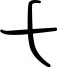

In [67]:
Image.fromarray(extract_bounding_box(img, bbs[1]))

In [68]:
Image.fromarray(extract_bounding_box(img, bbs[2]))

In [69]:
# Get max width and height
max_w = max([bb[2] for bb in bbs])
max_h = max([bb[3] for bb in bbs])

1/1 [==============================] - 0s 42ms/step
['[']


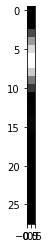

1/1 [==============================] - 0s 28ms/step
['+']


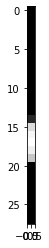

1/1 [==============================] - 0s 25ms/step
['+']


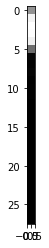

In [71]:
count = 0
for bb in bbs:
    (x, y, w, h, a) = bb
    char = extract_bounding_box(img, bb)
    # pad_width = int((max_w - w) / 2) + 20
    # # pad_height = int((max_h - h) / 2) + 20
    # pad_width = w // 2
    # pad_height = 5
    # char = cv2.copyMakeBorder(char, pad_height, pad_height, pad_width, pad_width,
    #                          cv2.BORDER_CONSTANT, value=255)
    # kernel = np.ones((2, 2), np.uint8)  # Adjust kernel size as needed
    # char = cv2.erode(char, kernel, iterations=2)
    char = cv2.resize(char, (28, 28))
    char = cv2.bitwise_not(char)
    char = char.astype(np.float32) / 255.0
    char = char.reshape(-1, 28, 28, 1)
    # cv2.imwrite('x_segmented_' + str(count) +'.png', char) 
    yh_test = MATH_best.predict(char).argmax(axis=1)
    print(label_encoder.inverse_transform(yh_test))
    count += 1
    plt.imshow(char[0][0], cmap='gray')
    plt.show()
    # break
# yh_test

In [232]:
yh_test

array([8])

In [45]:
list(label_encoder.classes_)

['%',
 '*',
 '+',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '[',
 ']']

In [46]:
im = cv2.imread("1_1_0.png", cv2.IMREAD_GRAYSCALE)
im = cv2.bitwise_not(im)
im = im.astype(np.float32) / 255.0
im

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0

In [47]:
im = im.reshape(-1, 28, 28, 1)
im

array([[[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
      

In [48]:
yh_test = MATH_best.predict(im).argmax(axis=1)
print(label_encoder.inverse_transform(yh_test))

1/1 [==============================] - 0s 51ms/step
['1']


In [35]:
train_y[-1]

1

In [39]:
train_x[-1]

array([[[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        